# Colab Init

In [1]:
if 'google.colab' in str(get_ipython()):
    print('Running on Colab')
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    %cd /content/drive/MyDrive/tcr-embedding/example/

In [2]:
if 'google.colab' in str(get_ipython()):
    !pip install comet-ml scanpy scirpy

# Config

In [3]:
from comet_ml import Experiment
import scanpy as sc
import scirpy as ir
import pandas as pd
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
import sys
sys.path.append('../')
import tcr_embedding as tcr

In [5]:
CONFIG_NAME = 'single_seq'
current_datetime = datetime.now().strftime("%Y%m%d-%H.%M")
experiment_name = '10x_' + CONFIG_NAME + '_' + current_datetime

In [6]:
experiment_name

'10x_single_seq_20210308-15.45'

In [7]:
%load_ext autoreload
%autoreload 2

# Load dataset

### 10x Dataset

In [8]:
adata = sc.read_h5ad('../data/10x_CD8TC/v5_train_val_test.h5ad')
adata

AnnData object with n_obs × n_vars = 128587 × 5000
    obs: 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'has_ir', 'multi_chain', 'barcode', 'donor', 'cell_clono_cdr3_aa', 'cell_clono_cdr3_nt', 'CD3', 'CD19', 'CD45RA', 'CD4', 'CD8a', 'CD14', 'CD45RO', 'CD279_PD-1', 'IgG1', 'IgG2a', 'IgG2b

### Split data into train and val, filter out test set to keep it untouched

In [9]:
adata.obs['set'].value_counts() / len(adata)

train    0.681577
test     0.162987
val      0.155436
Name: set, dtype: float64

In [10]:
adata = adata[adata.obs['set'] != 'test']
adata.obs['set'].value_counts() / len(adata)

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


train    0.814297
val      0.185703
Name: set, dtype: float64

In [11]:
train_adata = adata[adata.obs['set'] == 'train']
val_adata = adata[adata.obs['set'] == 'val']

# Initialize and train model

In [12]:
with open(f'../config/{CONFIG_NAME}.yaml') as file:
     params = yaml.load(file)
params

<ipython-input-12-8d8c92f489fc>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(file)


{'seq_model_arch': 'BiGRU',
 'seq_model_hyperparams': {'embedding_dim': 64,
  'hidden_size': 256,
  'num_layers': 2,
  'dropout': 0.1,
  'bidirectional': True},
 'scRNA_model_arch': 'None',
 'scRNA_model_hyperparams': {'gene_hidden': [800],
  'activation': 'leakyrelu',
  'output_activation': 'relu',
  'dropout': 0.2,
  'batch_norm': True},
 'hdim': 800,
 'activation': 'leakyrelu',
 'dropout': 0.2,
 'batch_norm': True,
 'shared_hidden': [200],
 'zdim': 100,
 'lr': 0.001,
 'batch_size': 256,
 'losses': ['MSE', 'CE'],
 'loss_weights': [0.1, 1.0, 5e-05]}

#### If Comet ML is not wanted, set experiment=None

In [13]:
with open('../comet_ml_key/API_key.txt') as f:
    COMET_ML_KEY = f.read()

experiment = Experiment(api_key=COMET_ML_KEY, workspace='tcr', project_name='10x_baseline')
experiment.log_parameters(params)
experiment.log_parameter('experiment_name', experiment_name)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/tcr/10x-baseline/3dfa93b767ee4cb18cc1414e01329d58



In [14]:
model = tcr.models.single_model.SingleModel(
    adatas=[adata],  # adatas containing gene expression and TCR-seq
    names=['10x'],
    aa_to_id = adata.uns['aa_to_id'],  # dict {aa_char: id}
    seq_model_arch=params['seq_model_arch'],  # seq model architecture
    seq_model_hyperparams=params['seq_model_hyperparams'],  # dict of seq model hyperparameters
    scRNA_model_arch=params['scRNA_model_arch'],
    scRNA_model_hyperparams=params['scRNA_model_hyperparams'],
    zdim=params['zdim'],  # zdim
    hdim=params['hdim'],  # hidden dimension of scRNA and seq encoders
    activation=params['activation'],  # activation function of autoencoder hidden layers
    dropout=params['dropout'],
    batch_norm=params['batch_norm'],
    shared_hidden=params['shared_hidden'],  # hidden layers of shared encoder / decoder
    gene_layers=[],  # [] or list of str for layer keys of each dataset
    seq_keys=[]  # [] or list of str for seq keys of each dataset
)

In [15]:
# print model architecture
model.model

SingleModelTorch(
  (seq_encoder): BiGRUEncoder(
    (embedding): Embedding(24, 64, padding_idx=0)
    (gru): GRU(64, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
    (output_layer): Linear(in_features=1024, out_features=800, bias=True)
  )
  (seq_decoder): BiGRUDecoder(
    (embedding): Embedding(24, 64, padding_idx=0)
    (hidden_state_layer): Linear(in_features=800, out_features=512, bias=True)
    (gru): GRU(64, 256, num_layers=2, batch_first=True, dropout=0.1)
    (output_layer): Linear(in_features=256, out_features=24, bias=True)
  )
  (shared_encoder): MLP(
    (network): Sequential(
      (0): Sequential(
        (0): Linear(in_features=800, out_features=200, bias=False)
        (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dropout(p=0.2, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=200, out_features=200, bias=Tr

In [16]:
model.train(
    experiment_name=experiment_name,
    n_iters=None,
    n_epochs=6,
    batch_size=params['batch_size'],
    lr=params['lr'],
    losses=params['losses'],  # list of losses for each modality: losses[0] := scRNA, losses[1] := TCR
    loss_weights=params['loss_weights'],  # [] or list of floats storing weighting of loss in order [scRNA, TCR, KLD]
    val_split='set',  # float or str, if float: split is determined automatically, if str: used as key for train-val column
    metadata=[],
    validate_every=5,
    print_every=5,
    save_every=25,
    num_workers=0,
    verbose=1,  # 0: only tdqm progress bar, 1: val loss, 2: train and val loss
#     continue_training=True,
    device=None,
    comet=experiment
)

Create Dataloader
Dataloader created


Epoch:   0%|                                                                                     | 0/6 [00:00<?, ?it/s]



Val Loss: 1.8142491579055786
Val scRNA Loss: 0.0
Val TCR Loss: 1.8052724599838257
Val KLD Loss: 0.008976981975138187


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 6/6 [04:13<00:00, 42.47s/it]



Val Loss: 1.3139729499816895
Val scRNA Loss: 0.0
Val TCR Loss: 1.3032505512237549
Val KLD Loss: 0.010722524486482143


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 6/6 [04:13<00:00, 42.21s/it]


In [17]:
model.history

,epoch,loss,scRNA_loss,TCR_loss,KLD_loss
0,0,1.814249,0.0,1.805272,0.008977
1,5,1.313973,0.0,1.303251,0.010723


In [18]:
model.train_history

,epoch,loss,scRNA_loss,TCR_loss,KLD_loss
0,0,1.654877,0.0,1.647757,0.007119
1,5,0.815679,0.0,0.805933,0.009746


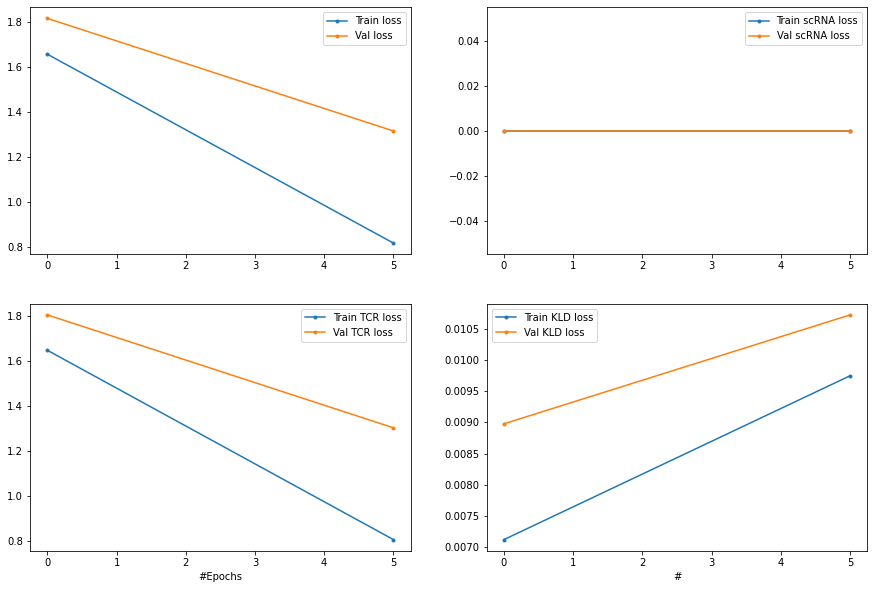

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.train_history['epoch'], model.train_history['loss'], '.-', label='Train loss');
plt.plot(model.history['epoch'], model.history['loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(222);
plt.plot(model.train_history['epoch'], model.train_history['scRNA_loss'], '.-', label='Train scRNA loss');
plt.plot(model.history['epoch'], model.history['scRNA_loss'], '.-', label='Val scRNA loss');
plt.legend();

plt.subplot(223);
plt.plot(model.train_history['epoch'], model.train_history['TCR_loss'], '.-', label='Train TCR loss');
plt.plot(model.history['epoch'], model.history['TCR_loss'], '.-', label='Val TCR loss');
plt.xlabel('#Epochs');
plt.legend();

plt.subplot(224);
plt.plot(model.train_history['epoch'], model.train_history['KLD_loss'], '.-', label='Train KLD loss');
plt.plot(model.history['epoch'], model.history['KLD_loss'], '.-', label='Val KLD loss');
plt.xlabel('#');
plt.legend();


# UMAP Plot of latent space

In [20]:
# List of antigens from David Fischer's paper, basically the 8 most common antigens
high_antigen_count = ['A0201_ELAGIGILTV_MART-1_Cancer_binder', 
                      'A0201_GILGFVFTL_Flu-MP_Influenza_binder', 
                      'A0201_GLCTLVAML_BMLF1_EBV_binder', 
                      'A0301_KLGGALQAK_IE-1_CMV_binder', 
                      'A0301_RLRAEAQVK_EMNA-3A_EBV_binder', 
                      'A1101_IVTDFSVIK_EBNA-3B_EBV_binder', 
                      'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder', 
                      'B0801_RAKFKQLL_BZLF1_EBV_binder']

### On Val Data

Filter cells with no binding data and only UMAP on high count antigen bindings

In [21]:
val_adata = val_adata[val_adata.obs['has_binding']]

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [22]:
val_adata.obs['binding_name'].value_counts()

A0301_KLGGALQAK_IE-1_CMV_binder                4228
B0801_RAKFKQLL_BZLF1_EBV_binder                1344
A1101_AVFDRKSDAK_EBNA-3B_EBV_binder            1211
A0201_GILGFVFTL_Flu-MP_Influenza_binder        1000
A1101_IVTDFSVIK_EBNA-3B_EBV_binder              150
A0201_GLCTLVAML_BMLF1_EBV_binder                 84
A0301_RLRAEAQVK_EMNA-3A_EBV_binder               59
A0201_ELAGIGILTV_MART-1_Cancer_binder            48
A0201_FLYALALLL_LMP2A_EBV_binder                 31
B0801_FLRGRAYGL_EBNA-3A_EBV_binder               22
A0201_LLDFVRFMGV_EBNA-3B_EBV_binder               7
A2402_AYAQKIFKI_IE-1_CMV_binder                   6
A0201_SLFNTVATLY_Gag-protein_HIV_binder           6
A0201_RTLNAWVKV_Gag-protein_HIV_binder            6
A0201_LLFGYPVYV_HTLV-1_binder                     5
A0201_FLASKIGRLV_Ca2-indepen-Plip-A2_binder       4
A0201_KTWGQYWQV_gp100_Cancer_binder               3
A0201_MLDLQPETT_16E7_HPV_binder                   2
A0201_KVLEYVIKV_MAGE-A1_Cancer_binder             2
A2402_CYTWNQ

In [23]:
val_adata

View of AnnData object with n_obs × n_vars = 8227 × 5000
    obs: 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'has_ir', 'multi_chain', 'barcode', 'donor', 'cell_clono_cdr3_aa', 'cell_clono_cdr3_nt', 'CD3', 'CD19', 'CD45RA', 'CD4', 'CD8a', 'CD14', 'CD45RO', 'CD279_PD-1', 'IgG1', 'IgG2a', 

Use last saved model

In [24]:
model.load(f'../saved_models/{experiment_name}_last_model.pt')

In [25]:
z = model.get_latent(
    adatas=[val_adata],
    names=['10x'],
    batch_size=256,
    num_workers=0,
    gene_layers=[],
    seq_keys=[],
    metadata=high_antigen_count + ['binding_name']
)

Batch: 100%|███████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.86it/s]


In [26]:
z

AnnData object with n_obs × n_vars = 8227 × 100
    obs: 'barcode', 'dataset', 'A0201_ELAGIGILTV_MART-1_Cancer_binder', 'A0201_GILGFVFTL_Flu-MP_Influenza_binder', 'A0201_GLCTLVAML_BMLF1_EBV_binder', 'A0301_KLGGALQAK_IE-1_CMV_binder', 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder', 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder', 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder', 'B0801_RAKFKQLL_BZLF1_EBV_binder', 'binding_name', 'batch'

In [27]:
sc.pp.neighbors(z, use_rep='X')
sc.tl.umap(z)

... storing 'dataset' as categorical
... storing 'A0201_ELAGIGILTV_MART-1_Cancer_binder' as categorical
... storing 'A0201_GILGFVFTL_Flu-MP_Influenza_binder' as categorical
... storing 'A0201_GLCTLVAML_BMLF1_EBV_binder' as categorical
... storing 'A0301_KLGGALQAK_IE-1_CMV_binder' as categorical
... storing 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder' as categorical
... storing 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder' as categorical
... storing 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder' as categorical
... storing 'B0801_RAKFKQLL_BZLF1_EBV_binder' as categorical
... storing 'binding_name' as categorical
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


{'web': 'https://www.comet.ml/api/image/download?imageId=c8a31ae027fa4978ab4298809b8febb2&experimentKey=3dfa93b767ee4cb18cc1414e01329d58',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=c8a31ae027fa4978ab4298809b8febb2&experimentKey=3dfa93b767ee4cb18cc1414e01329d58',
 'imageId': 'c8a31ae027fa4978ab4298809b8febb2'}

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

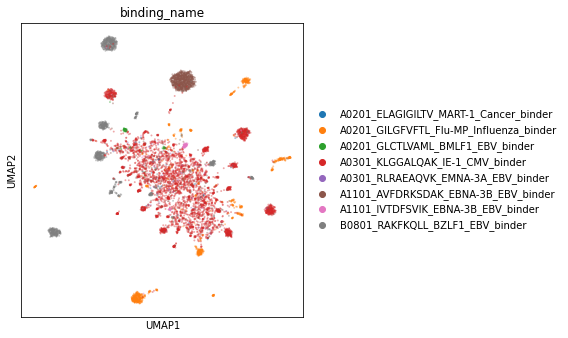

In [28]:
for antigen in high_antigen_count:
    ax = sc.pl.umap(z, color=antigen, return_fig=True, alpha=0.3)
    ax.tight_layout()
    experiment.log_figure(figure_name=f'val_{antigen}', figure=ax, step=model.epoch, overwrite=False)
    ax.clf()
ax = sc.pl.umap(z[z.obs['binding_name'].isin(high_antigen_count)], color='binding_name', return_fig=True, alpha=0.4)
ax.set_size_inches(8, 4.8)
ax.tight_layout()
experiment.log_figure(figure_name=f'val_binding_name', figure=ax, step=model.epoch, overwrite=False)

Use "best" saved model (currently based on val_loss)

In [29]:
model.load(f'../saved_models/{experiment_name}_best_model.pt')

In [30]:
z = model.get_latent(
    adatas=[val_adata],
    names=['10x'],
    batch_size=256,
    num_workers=0,
    gene_layers=[],
    seq_keys=[],
    metadata=high_antigen_count + ['binding_name']
)

Batch: 100%|███████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 20.69it/s]


In [31]:
sc.pp.neighbors(z, use_rep='X')
sc.tl.umap(z)

... storing 'dataset' as categorical
... storing 'A0201_ELAGIGILTV_MART-1_Cancer_binder' as categorical
... storing 'A0201_GILGFVFTL_Flu-MP_Influenza_binder' as categorical
... storing 'A0201_GLCTLVAML_BMLF1_EBV_binder' as categorical
... storing 'A0301_KLGGALQAK_IE-1_CMV_binder' as categorical
... storing 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder' as categorical
... storing 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder' as categorical
... storing 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder' as categorical
... storing 'B0801_RAKFKQLL_BZLF1_EBV_binder' as categorical
... storing 'binding_name' as categorical
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


{'web': 'https://www.comet.ml/api/image/download?imageId=e351b746e9814a8f92cab9665c566d25&experimentKey=3dfa93b767ee4cb18cc1414e01329d58',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=e351b746e9814a8f92cab9665c566d25&experimentKey=3dfa93b767ee4cb18cc1414e01329d58',
 'imageId': 'e351b746e9814a8f92cab9665c566d25'}

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

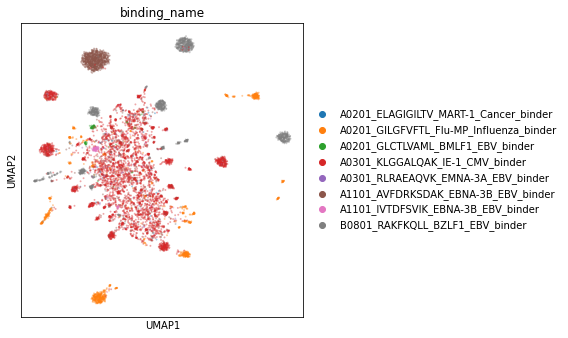

In [32]:
for antigen in high_antigen_count:
    ax = sc.pl.umap(z, color=antigen, return_fig=True, alpha=0.3)
    ax.tight_layout()
    experiment.log_figure(figure_name=f'val_{antigen}', figure=ax, step=model.epoch, overwrite=False)
    ax.clf()
ax = sc.pl.umap(z[z.obs['binding_name'].isin(high_antigen_count)], color='binding_name', return_fig=True, alpha=0.4)
ax.set_size_inches(8, 4.8)
ax.tight_layout()
experiment.log_figure(figure_name=f'val_binding_name', figure=ax, step=model.epoch, overwrite=False)

### On Train Data

Filter cells with no binding data and only UMAP on high count antigen bindings

In [33]:
train_adata = train_adata[train_adata.obs['has_binding']]

In [34]:
train_adata.obs['binding_name'].value_counts()

A0301_KLGGALQAK_IE-1_CMV_binder                    17792
B0801_RAKFKQLL_BZLF1_EBV_binder                    12979
A1101_IVTDFSVIK_EBNA-3B_EBV_binder                  5390
A0201_GILGFVFTL_Flu-MP_Influenza_binder             5142
A1101_AVFDRKSDAK_EBNA-3B_EBV_binder                 1929
A0201_GLCTLVAML_BMLF1_EBV_binder                    1027
A0301_RLRAEAQVK_EMNA-3A_EBV_binder                   245
A0201_ELAGIGILTV_MART-1_Cancer_binder                144
A0201_LLDFVRFMGV_EBNA-3B_EBV_binder                  114
A0201_FLYALALLL_LMP2A_EBV_binder                      55
A0201_RTLNAWVKV_Gag-protein_HIV_binder                22
A0201_LLFGYPVYV_HTLV-1_binder                         19
A0201_SLFNTVATLY_Gag-protein_HIV_binder               16
A0201_FLASKIGRLV_Ca2-indepen-Plip-A2_binder           14
A2402_AYAQKIFKI_IE-1_CMV_binder                       12
A2402_QYDPVAALF_pp65_CMV_binder                        9
B0801_FLRGRAYGL_EBNA-3A_EBV_binder                     8
A0201_KTWGQYWQV_gp100_Cancer_bi

In [35]:
train_adata

View of AnnData object with n_obs × n_vars = 44979 × 5000
    obs: 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'has_ir', 'multi_chain', 'barcode', 'donor', 'cell_clono_cdr3_aa', 'cell_clono_cdr3_nt', 'CD3', 'CD19', 'CD45RA', 'CD4', 'CD8a', 'CD14', 'CD45RO', 'CD279_PD-1', 'IgG1', 'IgG2a',

Use last saved model

In [36]:
model.load(f'../saved_models/{experiment_name}_last_model.pt')

In [37]:
z = model.get_latent(
    adatas=[train_adata],
    names=['10x'],
    batch_size=256,
    num_workers=0,
    gene_layers=[],
    seq_keys=[],
    metadata=high_antigen_count + ['binding_name']
)

Batch: 100%|█████████████████████████████████████████████████████████████████████████| 176/176 [00:08<00:00, 21.88it/s]


In [38]:
z

AnnData object with n_obs × n_vars = 44979 × 100
    obs: 'barcode', 'dataset', 'A0201_ELAGIGILTV_MART-1_Cancer_binder', 'A0201_GILGFVFTL_Flu-MP_Influenza_binder', 'A0201_GLCTLVAML_BMLF1_EBV_binder', 'A0301_KLGGALQAK_IE-1_CMV_binder', 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder', 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder', 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder', 'B0801_RAKFKQLL_BZLF1_EBV_binder', 'binding_name', 'batch'

In [39]:
sc.pp.neighbors(z, use_rep='X')
sc.tl.umap(z)

... storing 'dataset' as categorical
... storing 'A0201_ELAGIGILTV_MART-1_Cancer_binder' as categorical
... storing 'A0201_GILGFVFTL_Flu-MP_Influenza_binder' as categorical
... storing 'A0201_GLCTLVAML_BMLF1_EBV_binder' as categorical
... storing 'A0301_KLGGALQAK_IE-1_CMV_binder' as categorical
... storing 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder' as categorical
... storing 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder' as categorical
... storing 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder' as categorical
... storing 'B0801_RAKFKQLL_BZLF1_EBV_binder' as categorical
... storing 'binding_name' as categorical
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


{'web': 'https://www.comet.ml/api/image/download?imageId=b42da477204c47ccbc1b2fd469fe1dd7&experimentKey=3dfa93b767ee4cb18cc1414e01329d58',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=b42da477204c47ccbc1b2fd469fe1dd7&experimentKey=3dfa93b767ee4cb18cc1414e01329d58',
 'imageId': 'b42da477204c47ccbc1b2fd469fe1dd7'}

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

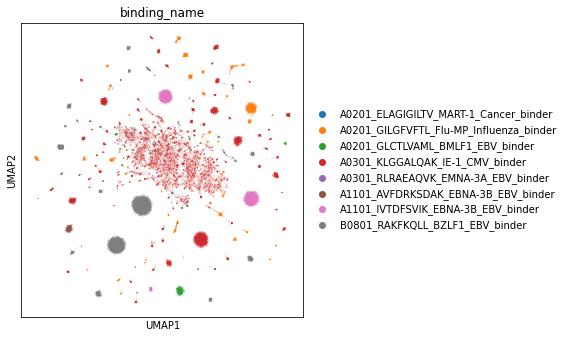

In [40]:
for antigen in high_antigen_count:
    ax = sc.pl.umap(z, color=antigen, return_fig=True, alpha=0.3)
    ax.tight_layout()
    experiment.log_figure(figure_name=f'train_{antigen}', figure=ax, step=model.epoch, overwrite=False)
    ax.clf()
ax = sc.pl.umap(z[z.obs['binding_name'].isin(high_antigen_count)], color='binding_name', return_fig=True, alpha=0.4)
ax.set_size_inches(8, 4.8)
ax.tight_layout()
experiment.log_figure(figure_name=f'train_binding_name', figure=ax, step=model.epoch, overwrite=False)

Use "best" saved model, (currently based on val loss)

In [41]:
model.load(f'../saved_models/{experiment_name}_best_model.pt')

In [42]:
z = model.get_latent(
    adatas=[train_adata],
    names=['10x'],
    batch_size=256,
    num_workers=0,
    gene_layers=[],
    seq_keys=[],
    metadata=high_antigen_count + ['binding_name']
)

Batch: 100%|█████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.29it/s]


In [43]:
sc.pp.neighbors(z, use_rep='X')
sc.tl.umap(z)

... storing 'dataset' as categorical
... storing 'A0201_ELAGIGILTV_MART-1_Cancer_binder' as categorical
... storing 'A0201_GILGFVFTL_Flu-MP_Influenza_binder' as categorical
... storing 'A0201_GLCTLVAML_BMLF1_EBV_binder' as categorical
... storing 'A0301_KLGGALQAK_IE-1_CMV_binder' as categorical
... storing 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder' as categorical
... storing 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder' as categorical
... storing 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder' as categorical
... storing 'B0801_RAKFKQLL_BZLF1_EBV_binder' as categorical
... storing 'binding_name' as categorical
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


{'web': 'https://www.comet.ml/api/image/download?imageId=d412143fdb174619963d4f65f6217413&experimentKey=3dfa93b767ee4cb18cc1414e01329d58',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=d412143fdb174619963d4f65f6217413&experimentKey=3dfa93b767ee4cb18cc1414e01329d58',
 'imageId': 'd412143fdb174619963d4f65f6217413'}

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

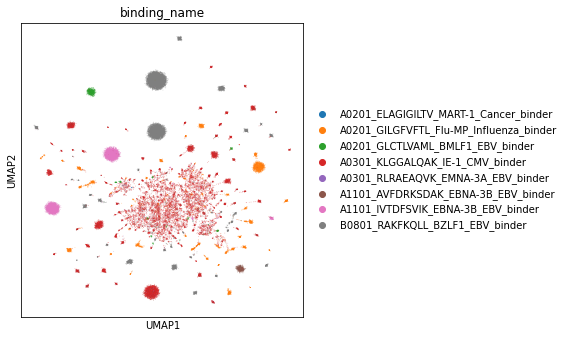

In [44]:
for antigen in high_antigen_count:
    ax = sc.pl.umap(z, color=antigen, return_fig=True, alpha=0.3)
    ax.tight_layout()
    experiment.log_figure(figure_name=f'train_{antigen}', figure=ax, step=model.epoch, overwrite=False)
    ax.clf()
ax = sc.pl.umap(z[z.obs['binding_name'].isin(high_antigen_count)], color='binding_name', return_fig=True, alpha=0.4)
ax.set_size_inches(8, 4.8)
ax.tight_layout()
experiment.log_figure(figure_name=f'train_binding_name', figure=ax, step=model.epoch, overwrite=False)

# kNN prediction

In [45]:
model.load(f'../saved_models/{experiment_name}_best_model.pt')

In [46]:
train_adata.obs['binding_name'].value_counts()

A0301_KLGGALQAK_IE-1_CMV_binder                    17792
B0801_RAKFKQLL_BZLF1_EBV_binder                    12979
A1101_IVTDFSVIK_EBNA-3B_EBV_binder                  5390
A0201_GILGFVFTL_Flu-MP_Influenza_binder             5142
A1101_AVFDRKSDAK_EBNA-3B_EBV_binder                 1929
A0201_GLCTLVAML_BMLF1_EBV_binder                    1027
A0301_RLRAEAQVK_EMNA-3A_EBV_binder                   245
A0201_ELAGIGILTV_MART-1_Cancer_binder                144
A0201_LLDFVRFMGV_EBNA-3B_EBV_binder                  114
A0201_FLYALALLL_LMP2A_EBV_binder                      55
A0201_RTLNAWVKV_Gag-protein_HIV_binder                22
A0201_LLFGYPVYV_HTLV-1_binder                         19
A0201_SLFNTVATLY_Gag-protein_HIV_binder               16
A0201_FLASKIGRLV_Ca2-indepen-Plip-A2_binder           14
A2402_AYAQKIFKI_IE-1_CMV_binder                       12
A2402_QYDPVAALF_pp65_CMV_binder                        9
B0801_FLRGRAYGL_EBNA-3A_EBV_binder                     8
A0201_KTWGQYWQV_gp100_Cancer_bi

In [47]:
val_adata.obs['binding_name'].value_counts()

A0301_KLGGALQAK_IE-1_CMV_binder                4228
B0801_RAKFKQLL_BZLF1_EBV_binder                1344
A1101_AVFDRKSDAK_EBNA-3B_EBV_binder            1211
A0201_GILGFVFTL_Flu-MP_Influenza_binder        1000
A1101_IVTDFSVIK_EBNA-3B_EBV_binder              150
A0201_GLCTLVAML_BMLF1_EBV_binder                 84
A0301_RLRAEAQVK_EMNA-3A_EBV_binder               59
A0201_ELAGIGILTV_MART-1_Cancer_binder            48
A0201_FLYALALLL_LMP2A_EBV_binder                 31
B0801_FLRGRAYGL_EBNA-3A_EBV_binder               22
A0201_LLDFVRFMGV_EBNA-3B_EBV_binder               7
A2402_AYAQKIFKI_IE-1_CMV_binder                   6
A0201_SLFNTVATLY_Gag-protein_HIV_binder           6
A0201_RTLNAWVKV_Gag-protein_HIV_binder            6
A0201_LLFGYPVYV_HTLV-1_binder                     5
A0201_FLASKIGRLV_Ca2-indepen-Plip-A2_binder       4
A0201_KTWGQYWQV_gp100_Cancer_binder               3
A0201_MLDLQPETT_16E7_HPV_binder                   2
A0201_KVLEYVIKV_MAGE-A1_Cancer_binder             2
A2402_CYTWNQ

In [48]:
z_train = model.get_latent(
    adatas=[train_adata],
    names=['10x'],
    batch_size=256,
    num_workers=0,
    gene_layers=[],
    seq_keys=[],
    metadata=['binding_name', 'binding_label']
)

Batch:   0%|                                                                                   | 0/176 [00:00<?, ?it/s]..\tcr_embedding\models\single_model.py:387: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  z.obs[metadata] = np.array(metadata_batch).T
Batch: 100%|█████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.99it/s]


In [49]:
z_val = model.get_latent(
    adatas=[val_adata],
    names=['10x'],
    batch_size=256,
    num_workers=0,
    gene_layers=[],
    seq_keys=[],
    metadata=['binding_name', 'binding_label']
)

Batch: 100%|███████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 21.76it/s]


Filter out cells that have rare antigen specificity

In [50]:
classes = 'binding_name'
z_train = z_train[z_train.obs[classes].isin(high_antigen_count)]
z_train.obs[classes].value_counts()

A0301_KLGGALQAK_IE-1_CMV_binder            17792
B0801_RAKFKQLL_BZLF1_EBV_binder            12979
A1101_IVTDFSVIK_EBNA-3B_EBV_binder          5390
A0201_GILGFVFTL_Flu-MP_Influenza_binder     5142
A1101_AVFDRKSDAK_EBNA-3B_EBV_binder         1929
A0201_GLCTLVAML_BMLF1_EBV_binder            1027
A0301_RLRAEAQVK_EMNA-3A_EBV_binder           245
A0201_ELAGIGILTV_MART-1_Cancer_binder        144
Name: binding_name, dtype: int64

In [51]:
z_val = z_val[z_val.obs[classes].isin(high_antigen_count)]
z_val.obs[classes].value_counts()

A0301_KLGGALQAK_IE-1_CMV_binder            4228
B0801_RAKFKQLL_BZLF1_EBV_binder            1344
A1101_AVFDRKSDAK_EBNA-3B_EBV_binder        1211
A0201_GILGFVFTL_Flu-MP_Influenza_binder    1000
A1101_IVTDFSVIK_EBNA-3B_EBV_binder          150
A0201_GLCTLVAML_BMLF1_EBV_binder             84
A0301_RLRAEAQVK_EMNA-3A_EBV_binder           59
A0201_ELAGIGILTV_MART-1_Cancer_binder        48
Name: binding_name, dtype: int64

In [52]:
model.kNN(z_train, z_val, classes, 5, 'distance')

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass weights=distance as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [53]:
z_val = z_val[z_val.obs[classes].isin(high_antigen_count) | z_val.obs['pred_'+classes].isin(high_antigen_count)]
z_val.shape

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(8124, 100)

In [54]:
from sklearn.metrics import classification_report
print(classification_report(z_val.obs[classes], z_val.obs['pred_'+classes]))
experiment.log_text(text=classification_report(z_val.obs[classes], z_val.obs['pred_'+classes]), step=model.epoch)

COMET WARNING: Empty mapping given to log_params({}); ignoring


                                         precision    recall  f1-score   support

  A0201_ELAGIGILTV_MART-1_Cancer_binder       0.25      0.02      0.04        48
A0201_GILGFVFTL_Flu-MP_Influenza_binder       0.87      0.86      0.86      1000
       A0201_GLCTLVAML_BMLF1_EBV_binder       0.33      0.15      0.21        84
        A0301_KLGGALQAK_IE-1_CMV_binder       0.70      0.95      0.81      4228
     A0301_RLRAEAQVK_EMNA-3A_EBV_binder       0.00      0.00      0.00        59
    A1101_AVFDRKSDAK_EBNA-3B_EBV_binder       0.97      0.62      0.75      1211
     A1101_IVTDFSVIK_EBNA-3B_EBV_binder       0.20      0.08      0.11       150
        B0801_RAKFKQLL_BZLF1_EBV_binder       0.70      0.28      0.40      1344

                               accuracy                           0.74      8124
                              macro avg       0.50      0.37      0.40      8124
                           weighted avg       0.74      0.74      0.71      8124



{'web': 'https://www.comet.ml/api/asset/download?assetId=f58f894990b44249926e7d1c638a35a8&experimentKey=3dfa93b767ee4cb18cc1414e01329d58',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=f58f894990b44249926e7d1c638a35a8&experimentKey=3dfa93b767ee4cb18cc1414e01329d58',
 'assetId': 'f58f894990b44249926e7d1c638a35a8'}

In [55]:
metrics = classification_report(z_val.obs[classes], z_val.obs['pred_'+classes], output_dict=True)
for antigen, metric in metrics.items():
    if antigen != 'accuracy':
        experiment.log_metrics(metric, prefix=antigen, step=model.epoch, epoch=model.epoch)
    else:
        experiment.log_metric('accuracy', metric, step=model.epoch, epoch=model.epoch)

In [56]:
experiment.log_confusion_matrix(matrix=pd.crosstab(z_val.obs[classes], z_val.obs['pred_'+classes]).values,
                                labels=pd.crosstab(z_val.obs[classes], z_val.obs['pred_'+classes]).index.to_list(),
                                step=model.epoch, epoch=model.epoch)

{'web': 'https://www.comet.ml/api/asset/download?assetId=dc438b88d4b848a0a46bcbadb8bf08d9&experimentKey=3dfa93b767ee4cb18cc1414e01329d58',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=dc438b88d4b848a0a46bcbadb8bf08d9&experimentKey=3dfa93b767ee4cb18cc1414e01329d58',
 'assetId': 'dc438b88d4b848a0a46bcbadb8bf08d9'}

In [57]:
pd.crosstab(z_val.obs[classes], z_val.obs['pred_'+classes])

pred_binding_name,A0201_ELAGIGILTV_MART-1_Cancer_binder,A0201_GILGFVFTL_Flu-MP_Influenza_binder,A0201_GLCTLVAML_BMLF1_EBV_binder,A0301_KLGGALQAK_IE-1_CMV_binder,A0301_RLRAEAQVK_EMNA-3A_EBV_binder,A1101_AVFDRKSDAK_EBNA-3B_EBV_binder,A1101_IVTDFSVIK_EBNA-3B_EBV_binder,B0801_RAKFKQLL_BZLF1_EBV_binder
binding_name,,,,,,,,
A0201_ELAGIGILTV_MART-1_Cancer_binder,1,0,0,46,0,0,0,1
A0201_GILGFVFTL_Flu-MP_Influenza_binder,0,858,1,136,0,0,0,5
A0201_GLCTLVAML_BMLF1_EBV_binder,0,5,13,65,0,0,0,1
A0301_KLGGALQAK_IE-1_CMV_binder,3,94,23,4030,1,15,12,50
A0301_RLRAEAQVK_EMNA-3A_EBV_binder,0,0,0,58,0,0,0,1
A1101_AVFDRKSDAK_EBNA-3B_EBV_binder,0,9,1,320,0,745,33,103
A1101_IVTDFSVIK_EBNA-3B_EBV_binder,0,2,0,130,0,1,12,5
B0801_RAKFKQLL_BZLF1_EBV_binder,0,16,2,939,0,5,2,380


In [58]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/tcr/10x-baseline/3dfa93b767ee4cb18cc1414e01329d58
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     A0201_ELAGIGILTV_MART-1_Cancer_binder_f1-score    : 0.038461538461538464
COMET INFO:     A0201_ELAGIGILTV_MART-1_Cancer_binder_precision   : 0.25
COMET INFO:     A0201_ELAGIGILTV_MART-1_Cancer_binder_recall      : 0.020833333333333332
COMET INFO:     A0201_ELAGIGILTV_MART-1_Cancer_binder_support     : 48
COMET INFO:     A0201_GILGFVFTL_Flu-MP_Influenza_binder_f1-score  : 0.8649193548387096
COMET INFO:     A0201_GILGFVFTL_Flu-MP_Influenza_binder_precision : 0.8719512195121951
COMET INFO:     A0201_GILGFVFTL_Flu-MP_Influenza_binder_recall    : 0.858
COMET INFO:     A0201_GILGFVFTL_Flu-MP_Influenza_binder_support   : 1000
COMET INFO:     A0201_